# Preliminary Experiments with Existing Algorithms Part 2: In-Processing algorithm- Adversarial Debiasing

In [1]:
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow as tf
import warnings; warnings.simplefilter('ignore')

import random
random.seed(0)

In [2]:
#Importing the datasets

#Adult
adult_orig = load_preproc_data_adult()

a_privileged_groups = [{'sex': 1}]
a_unprivileged_groups = [{'sex': 0}]

adult_orig_train, adult_orig_test = adult_orig.split([0.7], shuffle=True)

#German
german_orig = load_preproc_data_german()

for i in range(1000):
    if (german_orig.labels[i] == 2.0):
        german_orig.labels[i] = 0
    else:
        german_orig.labels[i] = 1
        
german_orig.favorable_label = 1
german_orig.unfavorable_label = 0

g_privileged_groups = [{'age': 1}]
g_unprivileged_groups = [{'age': 0}]

german_orig_train, german_orig_test = german_orig.split([0.7], shuffle=True)

#Scaling the datasets
std_scaler = StandardScaler()

#Adult
adult_orig_train.features = std_scaler.fit_transform(adult_orig_train.features)
adult_orig_test.features = std_scaler.transform(adult_orig_test.features)

#German
german_orig_train.features = std_scaler.fit_transform(german_orig_train.features)
german_orig_test.features = std_scaler.transform(german_orig_test.features)

In [3]:
#start a tesnforflow session for Adversarial Debiasing
sess = tf.Session()

# Learn parameters with debias set to True
#Debiasing Model for Adult dataset

adult_model = AdversarialDebiasing(privileged_groups = a_privileged_groups,
                          unprivileged_groups = a_unprivileged_groups,
                          scope_name='debiased_adult_classifier',
                          debias=True,
                          sess=sess)

adult_model.fit(adult_orig_train)

#pred_debiased_train_a = adult_model.predict(adult_orig_train)
pred_debiased_test_a = adult_model.predict(adult_orig_test)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 0.702637; batch adversarial loss: 0.643104
epoch 0; iter: 200; batch classifier loss: 0.446043; batch adversarial loss: 0.632510
epoch 1; iter: 0; batch classifier loss: 0.449528; batch adversarial loss: 0.631461
epoch 1; iter: 200; batch classifier loss: 0.565505; batch adversarial loss: 0.593458
epoch 2; iter: 0; batch classifier loss: 0.463715; batch adversarial loss: 0.62

epoch 30; iter: 200; batch classifier loss: 0.483944; batch adversarial loss: 0.657298
epoch 31; iter: 0; batch classifier loss: 0.448528; batch adversarial loss: 0.589990
epoch 31; iter: 200; batch classifier loss: 0.435900; batch adversarial loss: 0.643269
epoch 32; iter: 0; batch classifier loss: 0.508764; batch adversarial loss: 0.629034
epoch 32; iter: 200; batch classifier loss: 0.320070; batch adversarial loss: 0.614476
epoch 33; iter: 0; batch classifier loss: 0.455155; batch adversarial loss: 0.630397
epoch 33; iter: 200; batch classifier loss: 0.397175; batch adversarial loss: 0.599331
epoch 34; iter: 0; batch classifier loss: 0.433399; batch adversarial loss: 0.605128
epoch 34; iter: 200; batch classifier loss: 0.380709; batch adversarial loss: 0.571620
epoch 35; iter: 0; batch classifier loss: 0.424173; batch adversarial loss: 0.567642
epoch 35; iter: 200; batch classifier loss: 0.473366; batch adversarial loss: 0.597303
epoch 36; iter: 0; batch classifier loss: 0.333765; b

In [4]:
pred_debiased_test_a

               instance weights            features                       \
                                protected attribute                        
                                               race  sex Age (decade)=10   
instance names                                                             
6745                        1.0                 1.0  1.0       -0.230934   
40581                       1.0                 1.0  1.0       -0.230934   
33909                       1.0                 0.0  1.0       -0.230934   
20134                       1.0                 1.0  1.0       -0.230934   
6724                        1.0                 1.0  1.0       -0.230934   
...                         ...                 ...  ...             ...   
4350                        1.0                 1.0  0.0       -0.230934   
42342                       1.0                 1.0  1.0       -0.230934   
2981                        1.0                 1.0  1.0       -0.230934   
18369       

In [5]:
#Performance Metrics from Adult dataset predictions

metric_adult_debiased_test = BinaryLabelDatasetMetric(pred_debiased_test_a, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)



classified_adult_debiased_test = ClassificationMetric(adult_orig_test, 
                                                 pred_debiased_test_a,
                                                 unprivileged_groups=a_unprivileged_groups,
                                                 privileged_groups=a_privileged_groups)


display(Markdown("#### Debiased LR with Adult Test Set Fairness Performance (based on predictions)"))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
deb_aeo_a = classified_adult_debiased_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % deb_aeo_a)

#Disparate Impact ratio between privileged and unprivileged groups.
deb_di_a = classified_adult_debiased_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % deb_di_a)

#Demographic parity difference between privileged and unprivileged groups.
deb_spd_a = classified_adult_debiased_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % deb_spd_a)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
deb_ppd_a = classified_adult_debiased_test.positive_predictive_value(privileged=False) - classified_adult_debiased_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % deb_ppd_a)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_adult_debiased_test.consistency())


#Prediction performance metrics
TPRa = classified_adult_debiased_test.true_positive_rate() #recall
TNRa = classified_adult_debiased_test.true_negative_rate() #specificity
PPVa = classified_adult_debiased_test.positive_predictive_value() #precision
bal_acc_a = (TPRa+TNRa)/2
f1_a = 2*((PPVa*TPRa)/(PPVa+TPRa))

display(Markdown("#### Debiased LR with Adult Test Set Prediction Performance"))
print("Standard accuracy of logistic regression trained on German dataset without any mitigation = %f" % classified_adult_debiased_test.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset without any mitigation = %f" % bal_acc_a)
print("F1 score of logistic regression trained on German dataset without any mitigation = %f" % f1_a)

print("Detailed scores for Adult dataset")
print("Precision (PPV): %f" %PPVa)
print("Recall (TPR): %f" %TPRa)
print("Specificity (TNR): %f" %TNRa)
print("F1-score: %f" %f1_a)

#### Debiased LR with Adult Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = -0.016155
Disparate impact ratio between unprivileged and privileged groups = 0.632561
Demographic parity difference between unprivileged and privileged groups = -0.073772
Predictive Parity difference between unprivileged and privileged groups = -0.298572
Consistency of indivuals' predicted labels = 1.000000


#### Debiased LR with Adult Test Set Prediction Performance

Standard accuracy of logistic regression trained on German dataset without any mitigation = 0.791715
Balanced accuracy of logistic regression trained on German dataset without any mitigation = 0.668590
F1 score of logistic regression trained on German dataset without any mitigation = 0.497861
Detailed scores for Adult dataset
Precision (PPV): 0.584847
Recall (TPR): 0.433400
Specificity (TNR): 0.903781
F1-score: 0.497861


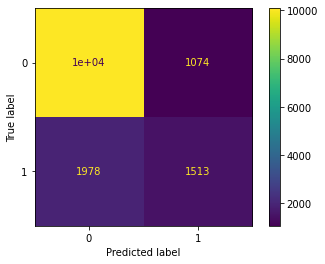

In [6]:
cm_adult = confusion_matrix(adult_orig_test.labels, pred_debiased_test_a.labels)

disp_adult = ConfusionMatrixDisplay(confusion_matrix=cm_adult)
disp_adult.plot()

In [7]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

#Debiasing model for German dataset
german_model = AdversarialDebiasing(privileged_groups = g_privileged_groups,
                          unprivileged_groups = g_unprivileged_groups,
                          scope_name='debiased_german_classifier',
                          debias=True,
                          sess=sess)


german_model.fit(german_orig_train)

#pred_debiased_train_g = german_model.predict(german_orig_train)
pred_debiased_test_g = german_model.predict(german_orig_test)

epoch 0; iter: 0; batch classifier loss: 0.746716; batch adversarial loss: 0.689986
epoch 1; iter: 0; batch classifier loss: 0.686425; batch adversarial loss: 0.670758
epoch 2; iter: 0; batch classifier loss: 0.605644; batch adversarial loss: 0.686718
epoch 3; iter: 0; batch classifier loss: 0.617251; batch adversarial loss: 0.664385
epoch 4; iter: 0; batch classifier loss: 0.591867; batch adversarial loss: 0.666315
epoch 5; iter: 0; batch classifier loss: 0.533945; batch adversarial loss: 0.683485
epoch 6; iter: 0; batch classifier loss: 0.581868; batch adversarial loss: 0.658815
epoch 7; iter: 0; batch classifier loss: 0.547423; batch adversarial loss: 0.671008
epoch 8; iter: 0; batch classifier loss: 0.587933; batch adversarial loss: 0.613524
epoch 9; iter: 0; batch classifier loss: 0.545257; batch adversarial loss: 0.669455
epoch 10; iter: 0; batch classifier loss: 0.532506; batch adversarial loss: 0.653805
epoch 11; iter: 0; batch classifier loss: 0.486039; batch adversarial loss:

In [8]:
pred_debiased_test_g

               instance weights            features                            \
                                protected attribute                             
                                                age  sex credit_history=Delay   
instance names                                                                  
135                         1.0                 1.0  0.0            -0.303387   
392                         1.0                 1.0  1.0            -0.303387   
14                          1.0                 1.0  0.0            -0.303387   
721                         1.0                 0.0  0.0            -0.303387   
773                         1.0                 1.0  1.0            -0.303387   
...                         ...                 ...  ...                  ...   
871                         1.0                 1.0  1.0            -0.303387   
444                         1.0                 1.0  0.0            -0.303387   
542                         

In [9]:
#Performance Metrics from German dataset predictions

metric_german_debiased_test = BinaryLabelDatasetMetric(pred_debiased_test_g, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)



classified_german_debiased_test = ClassificationMetric(german_orig_test, 
                                                 pred_debiased_test_g,
                                                 unprivileged_groups=g_unprivileged_groups,
                                                 privileged_groups=g_privileged_groups)


display(Markdown("#### Debiased LR with German Test Set Fairness Performance (based on predictions)"))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
deb_aeo_g = classified_german_debiased_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % deb_aeo_g)

#Disparate Impact ratio between privileged and unprivileged groups.
deb_di_g = classified_german_debiased_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % deb_di_g)

#Demographic parity difference between privileged and unprivileged groups.
deb_spd_g = classified_german_debiased_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % deb_spd_g)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
deb_ppd_g = classified_german_debiased_test.positive_predictive_value(privileged=False) - classified_german_debiased_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % deb_ppd_g)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_german_debiased_test.consistency())


#Prediction performance metrics
TPRg = classified_german_debiased_test.true_positive_rate() #recall
TNRg = classified_german_debiased_test.true_negative_rate() #specificity
PPVg = classified_german_debiased_test.positive_predictive_value() #precision
bal_acc_g = (TPRg+TNRg)/2
f1_g = 2*((PPVg*TPRg)/(PPVg+TPRg))

display(Markdown("#### Debiased LR with German Test Set Prediction Performance"))
print("Standard accuracy of logistic regression trained on German dataset without any mitigation = %f" % classified_german_debiased_test.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset without any mitigation = %f" % bal_acc_g)
print("F1 score of logistic regression trained on German dataset without any mitigation = %f" % f1_g)

print("Detailed scores for german dataset")
print("Precision (PPV): %f" %PPVg)
print("Recall (TPR): %f" %TPRg)
print("Specificity (TNR): %f" %TNRg)
print("F1-score: %f" %f1_g)

#### Debiased LR with German Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = 0.089572
Disparate impact ratio between unprivileged and privileged groups = 1.099099
Demographic parity difference between unprivileged and privileged groups = 0.090164
Predictive Parity difference between unprivileged and privileged groups = -0.220721
Consistency of indivuals' predicted labels = 0.992667


#### Debiased LR with German Test Set Prediction Performance

Standard accuracy of logistic regression trained on German dataset without any mitigation = 0.646667
Balanced accuracy of logistic regression trained on German dataset without any mitigation = 0.492034
F1 score of logistic regression trained on German dataset without any mitigation = 0.780083
Detailed scores for german dataset
Precision (PPV): 0.676259
Recall (TPR): 0.921569
Specificity (TNR): 0.062500
F1-score: 0.780083


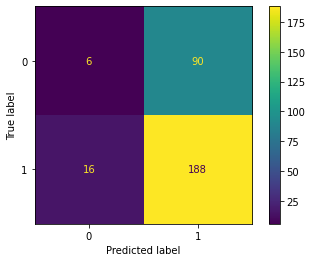

In [10]:
cm_german = confusion_matrix(german_orig_test.labels, pred_debiased_test_g.labels)

disp_german = ConfusionMatrixDisplay(confusion_matrix=cm_german)
disp_german.plot()

In [11]:
sess.close()